In [1]:
import JupyterNotebooksLib as slicernb
import numpy as np

this_notebook_name = "SpineSegmentationVisualTestFunctions"

In [2]:
# place paths to scenes to test here
scenes_to_reconstruct = [
    r"c:\Users\perkl\Documents\AIGT\OneDrive_1_5-12-2020\317_Ax_Ready.mrb",
    r"c:\Users\perkl\Documents\AIGT\SpineUsOutput\39_Sa_Ready.mrb"
]

# all paths to models to study
models = [
    r"c:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy-TF2_model-4_2020-06-23_19-47-30.h5",
    r"c:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy-TF2_model-7_2020-06-28_22-31-54.h5"
]

# folder to temporarily store images
image_output_path = 'C:/Users/perkl/Documents/AIGT/PNGs/Image_{}.png'

images_to_plot = np.array([])

# set to true to mute all diagnostic output except images
mute_output = True


# Input ultrasound sequence names

input_browser_name = r"LandmarkingScan"
input_image_name = r"Image_Image"

# Output will be saved using these names

output_browser_name = r"BonePredictionBrowser"
output_sequence_name = r"PredictionSequence"
output_image_name = r"PredictionImage"

# Optionally save output to numpy arrays

array_output = False
array_folder_name = r"Temp"
array_segmentation_name = r"segmentation"
array_ultrasound_name = r"ultrasound"

# Image processing parameters

# Erases the side of prediction images. 1.0 means the whole prediction is erased.
# Background should be the first component (i.e. y[:,:,:,0]) in the prediction output array.

clip_side_ratio = 0.3
apply_logarithmic_transformation = True
logarithmic_transformation_decimals = 4

# notebook output path
notebooks_save_path = r"c:\Data\SagittalSpineSegmentationStudy\SavedNotebooks"

# Volume rendering parameters
volRendWindow = 200
volRendLevel = 156
volRendColor1 = [0.1, 0.1, 0.0, 1]
volRendColor2 = [1.0, 0.9, 0.4, 1]

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

Save timestamp: 2020-07-08_23-41-06


In [3]:
import datetime
import os
import scipy.ndimage
import qt

import tensorflow as tf
from tensorflow.keras.models import load_model

# from local_vars import root_folder

In [4]:
parent_folder = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(parent_folder)

import Models.segmentation_unet as unet
import utils

In [5]:
def setup(scene):
    # loading scene
    if not mute_output:
        print("Loading scene from " + scene)
    
    slicer.mrmlScene.Clear()
    try:
        slicer.util.loadScene(scene)
    except:
        # NOTE: for some reason loading a scene throws an error every time, but laods the scene just fine
        if not mute_output:
            print('Error thrown. Continuing.')
        
    # changing transform hierarchy
    image_image = slicer.util.getFirstNodeByName(input_image_name)
    imageToTransd = slicer.util.getFirstNodeByName("ImageToTransd")

    image_image.SetAndObserveTransformNodeID(None)
    image_image.SetAndObserveTransformNodeID(imageToTransd.GetID())
    
    
    slicer.app.layoutManager().setLayout(slicer.vtkMRMLLayoutNode.SlicerLayoutOneUp3DView)
    
    #hide skeleton model
    skeleton = slicer.util.getFirstNodeByName("SkeletonModel")
    if skeleton is not None:
        skeleton.SetDisplayVisibility(False)

In [6]:
def load_model(model_fullname):
    # Check if keras model file exists. Abort if not found. Load model otherwise.

    if not os.path.exists(model_fullname):
        raise Exception("Could not find model: " + model_fullname)

    if not mute_output:
        print("Loading model from: " + model_fullname)

    if array_output:
        array_output_fullpath = os.path.join(root_folder, array_folder_name)
        array_segmentation_fullname = os.path.join(array_output_fullpath, array_segmentation_name)
        array_ultrasound_fullname = os.path.join(array_output_fullpath, array_ultrasound_name)
        if not os.path.exists(array_output_fullpath):
            os.mkdir(array_output_fullpath)
            if not mute_output:
                print("Folder created: {}".format(array_output_fullpath))
        
        if not mute_output:
            print("Will save segmentation output to {}".format(array_segmentation_fullname))
            print("Will save ultrasound output to   {}".format(array_ultrasound_fullname))

    model = tf.keras.models.load_model(model_fullname, compile=False)
    return model

    # model.summary()

In [7]:
def segment(model):
    # Check input. Abort if browser or image doesn't exist.

    input_browser_node = slicer.util.getFirstNodeByName(input_browser_name, className='vtkMRMLSequenceBrowserNode')
    input_image_node = slicer.util.getFirstNodeByName(input_image_name, className="vtkMRMLScalarVolumeNode")

    if input_browser_node is None:
        logging.error("Could not find input browser node: {}".format(input_browser_node))
        raise

    if input_image_node is None:
        logging.error("Could not find input image node: {}".format(input_image_name))
        raise

    # Create output image and browser for segmentation output.

    output_browser_node = slicer.util.getFirstNodeByName(output_browser_name, className='vtkMRMLSequenceBrowserNode')
    if output_browser_node is None:
        output_browser_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLSequenceBrowserNode', output_browser_name)

    output_sequence_node = slicer.util.getFirstNodeByName(output_sequence_name, className="vtkMRMLSequenceNode")
    if output_sequence_node is None:
        output_sequence_node = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLSequenceNode', output_sequence_name)
        output_browser_node.AddSynchronizedSequenceNode(output_sequence_node)

    output_image_node = slicer.util.getFirstNodeByName(output_image_name, className="vtkMRMLScalarVolumeNode")
    # browser_logic = slicer.modules.sequences.logic()
    if output_image_node is None:
        volumes_logic = slicer.modules.volumes.logic()
        output_image_node = volumes_logic.CloneVolume(slicer.mrmlScene, input_image_node, output_image_name)
        browser_logic = slicer.modules.sequences.logic()
        browser_logic.AddSynchronizedNode(output_sequence_node, output_image_node, output_browser_node)

    output_browser_node.SetRecording(output_sequence_node, True)

    # Add all input sequences to the output browser for being able to conveniently replay everything

    proxy_collection = vtk.vtkCollection()
    input_browser_node.GetAllProxyNodes(proxy_collection)

    for i in range(proxy_collection.GetNumberOfItems()):
        proxy_node = proxy_collection.GetItemAsObject(i)
        output_sequence = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLSequenceNode')
        browser_logic.AddSynchronizedNode(output_sequence, proxy_node, output_browser_node)
        output_browser_node.SetRecording(output_sequence, True)

    # Iterate input sequence, compute segmentation for each frame, record output sequence.

    num_items = input_browser_node.GetNumberOfItems()
    n = num_items
    input_browser_node.SelectFirstItem()

    input_array = slicer.util.array(input_image_node.GetID())
    slicer_to_model_scaling = model.layers[0].input_shape[0][1] / input_array.shape[1]
    model_to_slicer_scaling = input_array.shape[1] / model.layers[0].input_shape[0][1]

    if not mute_output:
        print("Will segment {} images".format(n))

    if array_output:
        array_output_ultrasound = np.zeros((n, input_array.shape[1], input_array.shape[1]))
        array_output_segmentation = np.zeros((n, input_array.shape[1], input_array.shape[1]), dtype=np.uint8)

    model_output_size = model.layers[-1].output_shape[1]
    num_output_components = model.layers[-1].output_shape[3]

    mask_model = np.ones([model_output_size, model_output_size])
    mask_model_background = np.zeros([model_output_size, model_output_size])

    columns_to_mask = int(model_output_size / 2 * clip_side_ratio)
    if not mute_output:
        print("Will mask {} columns on both sides".format(columns_to_mask))

    mask_model[:,:columns_to_mask] = 0
    mask_model[:,-columns_to_mask:] = 0
    mask_model_background[:,:columns_to_mask] = 1
    mask_model_background[:,-columns_to_mask:] = 1

    # Display mask

    # import matplotlib
    # matplotlib.use('WXAgg')

    # from matplotlib import pyplot as plt

    # plt.imshow(mask_model[:,:])
    # plt.show()

    start_timestamp = datetime.datetime.now()
    if not mute_output:
        print("Processing started at: {}".format(start_timestamp.strftime('%H-%M-%S')))


    for i in range(n):
        # if i > 10:  # todo Just for debugging
        #     break
        input_array = slicer.util.array(input_image_node.GetID())

        if array_output:
            array_output_ultrasound[i, :, :] = input_array[0, :, :]

        resized_input_array = scipy.ndimage.zoom(input_array[0,:,:], slicer_to_model_scaling)
        resized_input_array = np.flip(resized_input_array, axis=0)
        resized_input_array = resized_input_array / resized_input_array.max()  # Scaling intensity to 0-1
        resized_input_array = np.expand_dims(resized_input_array, axis=0)
        resized_input_array = np.expand_dims(resized_input_array, axis=3)
        y = model.predict(resized_input_array)
        if apply_logarithmic_transformation:
            e = logarithmic_transformation_decimals
            y = np.log10(np.clip(y, 10**(-e), 1.0)*(10**e))/e
        y[0,:,:,:] = np.flip(y[0,:,:,:], axis=0)

        for component in range(1, num_output_components):
            y[0,:,:,component] = y[0,:,:,component] * mask_model[:,:]
        y[0,:,:,0] = np.maximum(y[0,:,:,0], mask_model_background)

        upscaled_output_array = scipy.ndimage.zoom(y[0,:,:,1], model_to_slicer_scaling)
        upscaled_output_array = upscaled_output_array * 255
        upscaled_output_array = np.clip(upscaled_output_array, 0, 255)

        if array_output:
            array_output_segmentation[i, :, :] = upscaled_output_array[:, :].astype(np.uint8)

        # output_array = slicer.util.array(output_image_node.GetID())
        # output_array[0, :, :] = upscaled_output_array[:, :].astype(np.uint8)

        slicer.util.updateVolumeFromArray(output_image_node, upscaled_output_array.astype(np.uint8)[np.newaxis, ...])

        output_browser_node.SaveProxyNodesState()
        input_browser_node.SelectNextItem()

        # If Slicer crashes during processing, try commenting this following line out and run this notebook again.
        slicer.app.processEvents()


    stop_timestamp = datetime.datetime.now()
    if not mute_output:
        print("Processing finished at: {}".format(stop_timestamp.strftime('%H-%M-%S')))


    if array_output:
        np.save(array_ultrasound_fullname, array_output_ultrasound)
        np.save(array_segmentation_fullname, array_output_segmentation)
        if not mute_output:
            print("Saved {}".format(array_ultrasound_fullname))
            print("Saved {}".format(array_segmentation_fullname))

    time_seconds = (stop_timestamp - start_timestamp).total_seconds()
    if not mute_output:
        print("Processed {} frames in {:.2f} seconds".format(n, time_seconds))
        print("FPS = {:.2f}".format(n / time_seconds))

In [8]:
def reconstruct_volume():
    # Find input volume (image) for volume reconstruction

    predictionVolume = slicer.mrmlScene.GetFirstNodeByName("PredictionImage")
    if predictionVolume is None:
        raise Exception("PredictionImage not found in Slicer scene")

    # Create output volume node

    reconstructedVolume = slicer.mrmlScene.GetFirstNodeByName("AiVolume")
    if reconstructedVolume is None:
        reconstructedVolume = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode")
        reconstructedVolume.SetName("AiVolume")

    inputBrowserNode = slicer.mrmlScene.GetFirstNodeByName("BonePredictionBrowser")
    if inputBrowserNode is None:
        raise Exception("BonePredictionBrowser missing")

    # Prepare volume reconstructor node

    volumeReconstructor = slicer.mrmlScene.GetFirstNodeByName("AiVolumeReconstructor")
    if volumeReconstructor is None:
        volumeReconstructor = slicer.vtkMRMLVolumeReconstructionNode()
        volumeReconstructor.SetName("AiVolumeReconstructor")
        volumeReconstructor.SetLiveVolumeReconstruction(False)
        volumeReconstructor.SetOptimizationMode(slicer.vtkMRMLVolumeReconstructionNode.FULL_OPTIMIZATION)
        volumeReconstructor.SetCompoundingMode(slicer.vtkMRMLVolumeReconstructionNode.MAXIMUM_COMPOUNDING_MODE)
        volumeReconstructor.SetInterpolationMode(slicer.vtkMRMLVolumeReconstructionNode.LINEAR_INTERPOLATION)
        slicer.mrmlScene.AddNode(volumeReconstructor)

    volumeReconstructor.SetAndObserveInputSequenceBrowserNode(inputBrowserNode)
    volumeReconstructor.SetAndObserveOutputVolumeNode(reconstructedVolume)
    volumeReconstructor.SetAndObserveInputVolumeNode(predictionVolume)

    volumeReconstructionLogic = slicer.modules.volumereconstruction.logic()

    # Volume reconstruction

    volumeReconstructionLogic.ReconstructVolumeFromSequence(volumeReconstructor)

In [9]:
def render_volume():
    # Volume rendering

    # find input volume
    aivolumeNode = slicer.mrmlScene.GetFirstNodeByName("AiVolume")
    if aivolumeNode is None:
        raise Exception("AiVolume node was never constructed")

    # find or build ROI
    annotationROINode = slicer.mrmlScene.GetFirstNodeByName("AnnotationROI")
    if annotationROINode is None:
        annotationROINode = slicer.vtkMRMLAnnotationROINode()
        annotationROINode.SetName("AnnotationROI")
        slicer.mrmlScene.AddNode(annotationROINode)
        annotationROINode.SetDisplayVisibility(False)

    # find or build volume property
    propertyPresetNode = slicer.mrmlScene.GetFirstNodeByName("volMR-Default")
    if propertyPresetNode is None:
        propertyPresetNode = slicer.vtkMRMLVolumePropertyNode()
        propertyPresetNode.SetName("volMR-Default")
        volumeRenderingLogic = slicer.modules.volumerendering.logic()
        propertyPresetNode.Copy(volumeRenderingLogic.GetPresetByName('MR-Default'))
        slicer.mrmlScene.AddNode(propertyPresetNode)

    # build 3D renderer
    volumeRenderingLogic = slicer.modules.volumerendering.logic()
    displayNode = volumeRenderingLogic.GetFirstVolumeRenderingDisplayNode(aivolumeNode)
    if displayNode is None:
        displayNode = slicer.vtkMRMLGPURayCastVolumeRenderingDisplayNode()
        displayNode.SetName("AiVolumeRenderer")
        slicer.mrmlScene.AddNode(displayNode)

        aivolumeNode.AddAndObserveDisplayNodeID(displayNode.GetID())

        displayNode.SetAndObserveVolumePropertyNodeID(propertyPresetNode.GetID())
        displayNode.SetAndObserveROINodeID(annotationROINode.GetID())

    # Set up custom volume rendering parameters

    lut = vtk.vtkLookupTable()
    lut.SetNumberOfTableValues(2)
    lut.Build()
    lut.SetTableValue(0, volRendColor1)
    lut.SetTableValue(1, volRendColor2)

    volumeProperty = displayNode.GetVolumePropertyNode().GetVolumeProperty()
    volumeRenderingLogic.SetThresholdToVolumeProp(
        [0, 500],
        [volRendLevel - volRendWindow / 2.0, volRendLevel + volRendWindow / 2.0],
        volumeProperty,
        True,
        True)
    upper = min(255, volRendLevel + volRendWindow / 2)
    lower = max(0, volRendLevel - volRendWindow / 2)
    volumeRenderingLogic.SetWindowLevelToVolumeProp(
        [0, 255],
        [upper - lower, lower + (upper - lower) / 2],
        lut,
        volumeProperty)


    displayNode.SetVisibility(True)

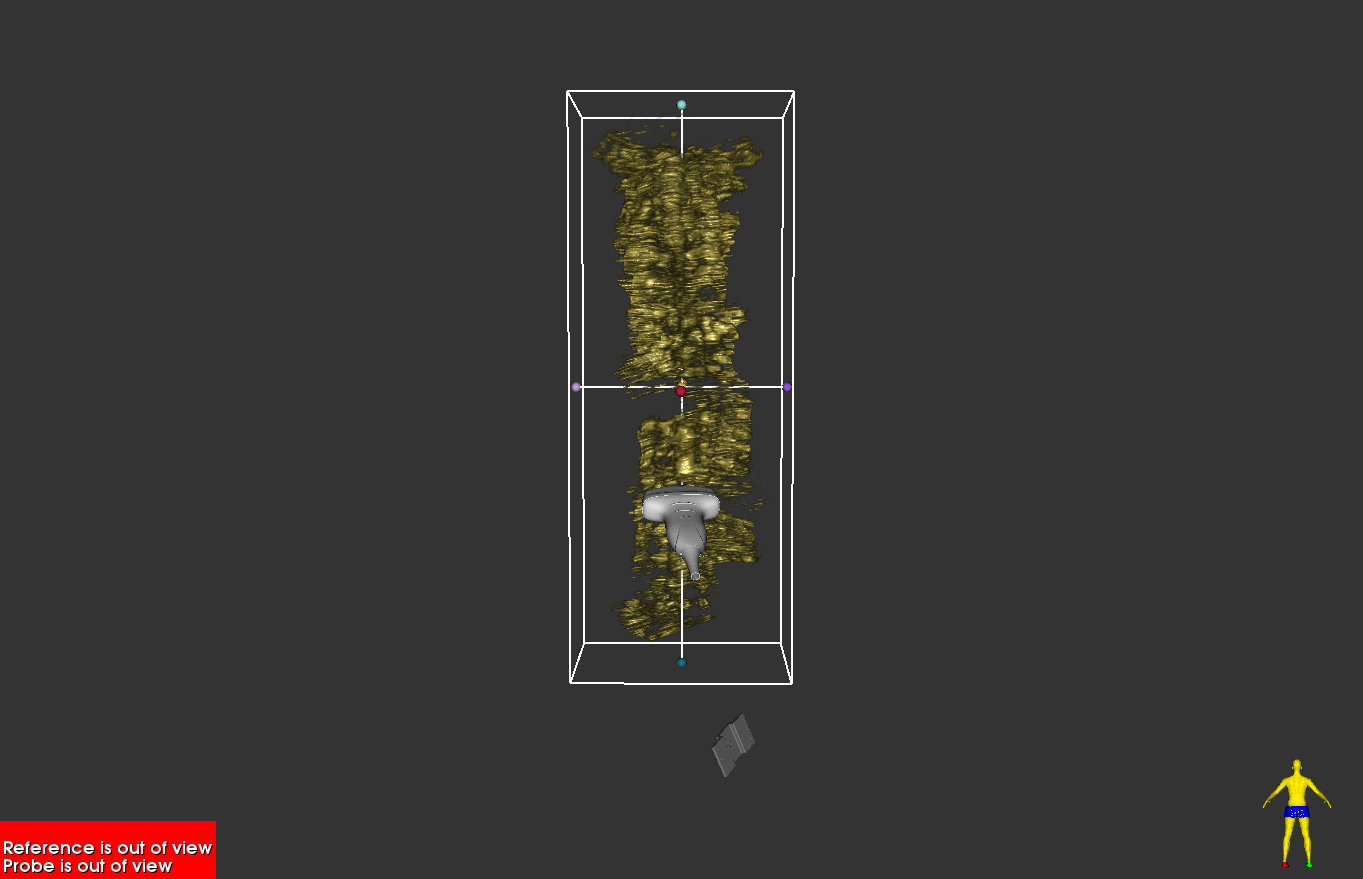

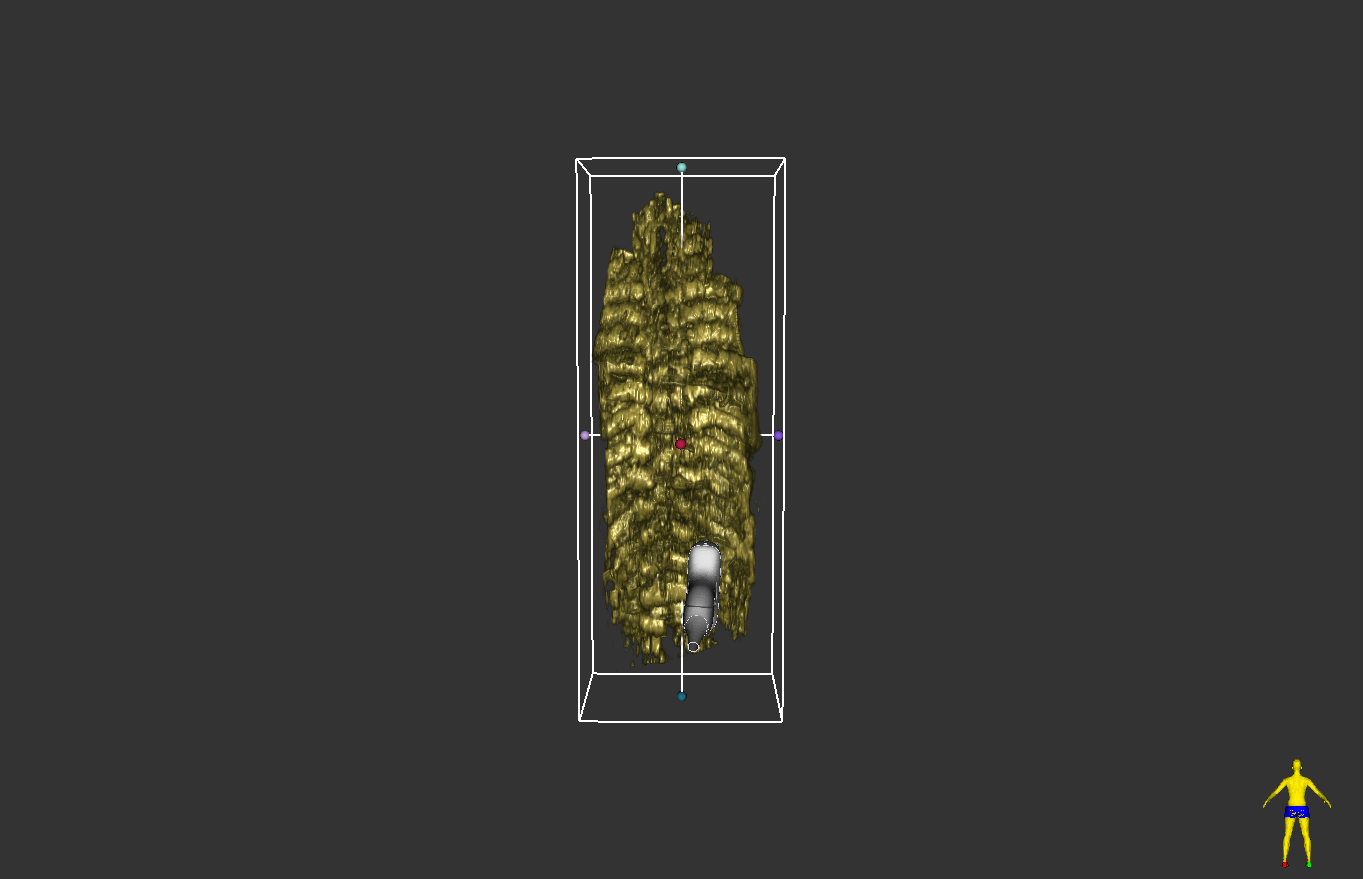

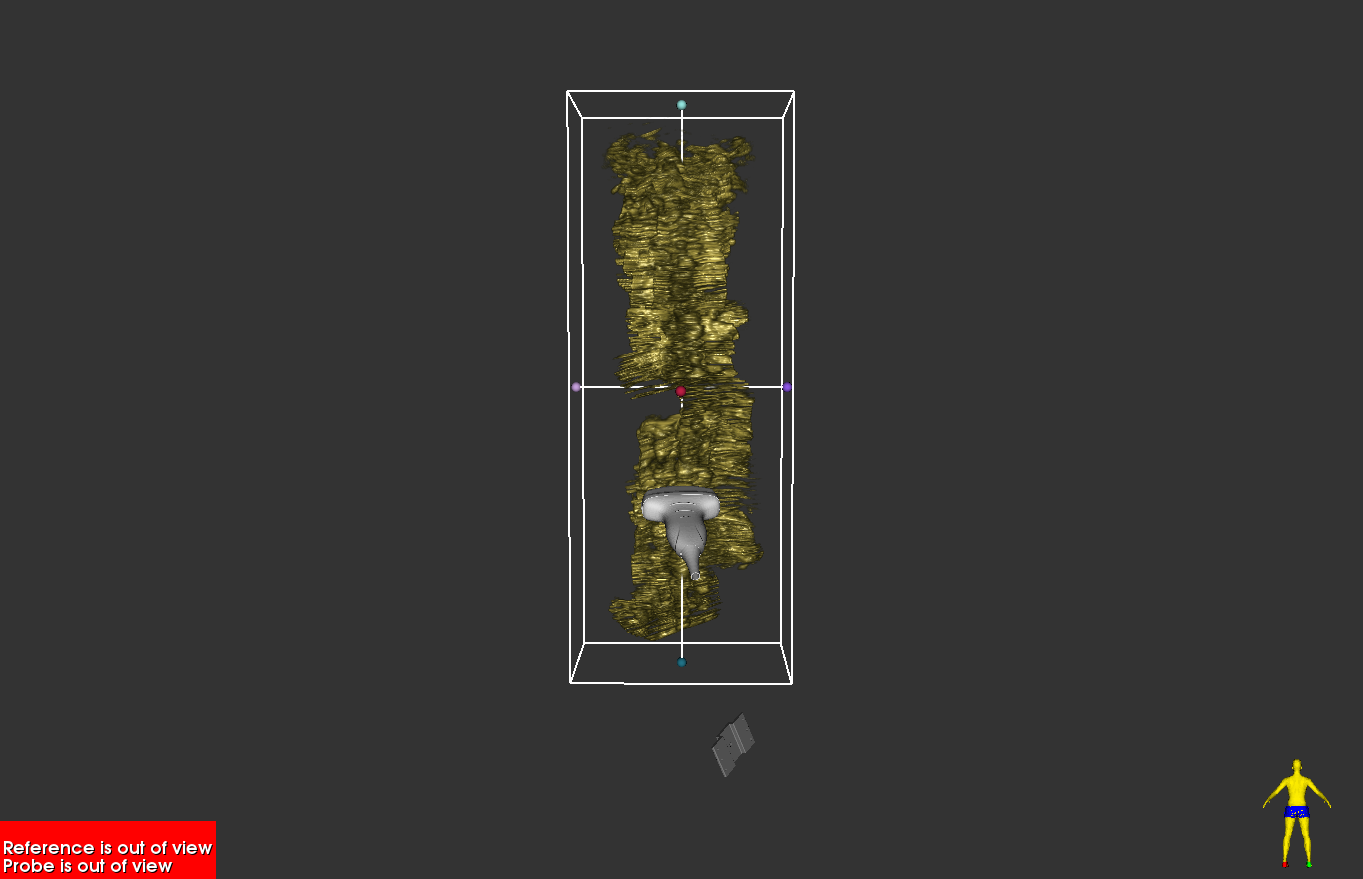

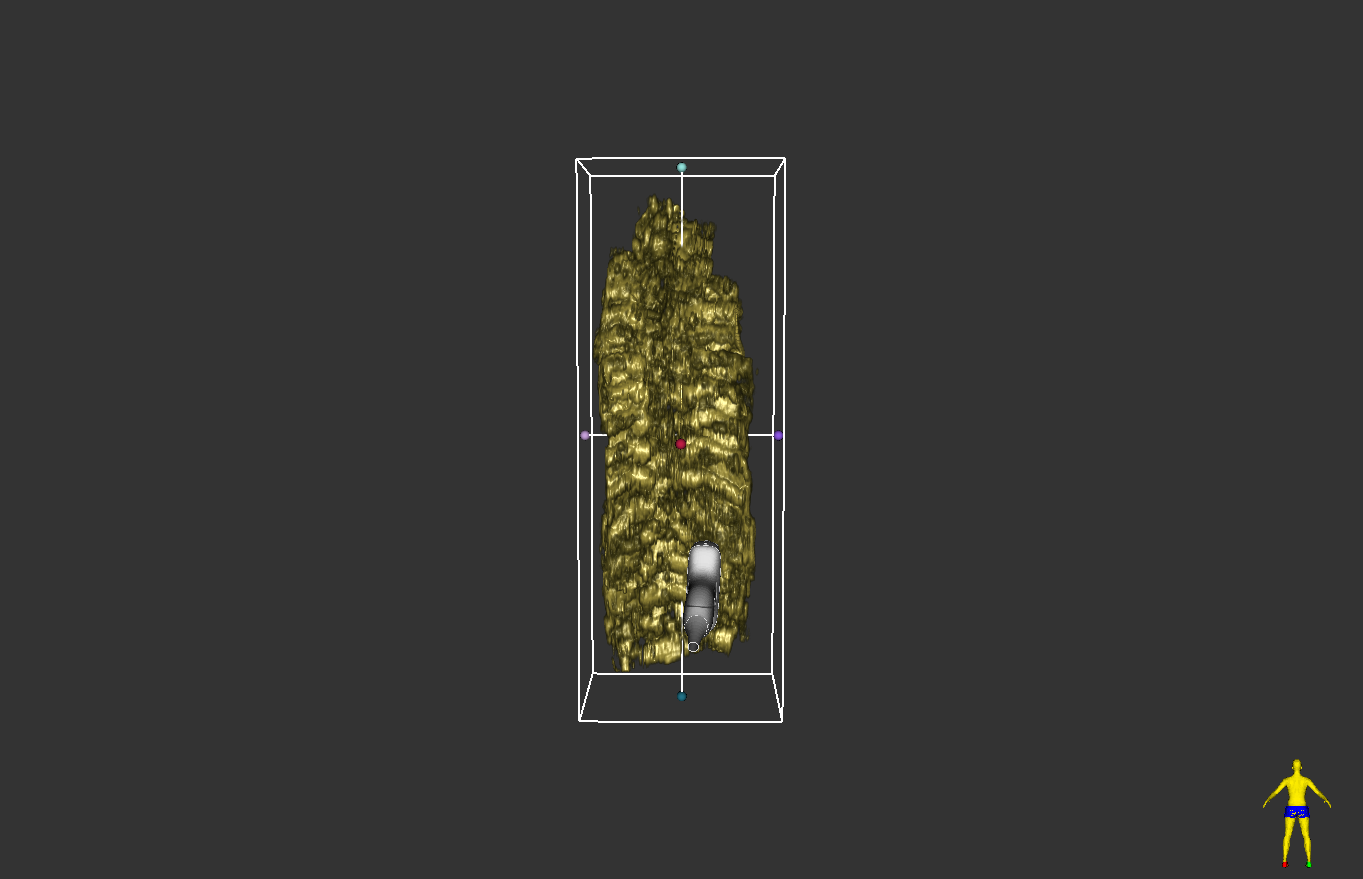

In [10]:
count = 0

for model in models:
    for scene in scenes_to_reconstruct:
        setup(scene)

        segment(load_model(model))

        reconstruct_volume()
        render_volume()

        full_image_path = image_output_path.format(str(count))
        count += 1
        images_to_plot = np.append(images_to_plot, full_image_path)
        
        display(slicernb.ViewDisplay())

        renderWindow = slicer.app.layoutManager().threeDWidget(0).threeDView().renderWindow()
        renderWindow.SetAlphaBitPlanes(1)
        wti = vtk.vtkWindowToImageFilter()
        wti.SetInputBufferTypeToRGBA()
        wti.SetInput(renderWindow)
        writer = vtk.vtkPNGWriter()
        writer.SetFileName(full_image_path)
        writer.SetInputConnection(wti.GetOutputPort())
        writer.Write()

In [11]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

In [12]:
import nbformat
from nbconvert import HTMLExporter
import json

notebook_path = slicernb.notebookPath()

with open(notebook_path, mode="r") as f:
    file_json = json.load(f)
    
notebook_content = nbformat.reads(json.dumps(file_json), as_version=4)

html_exporter = HTMLExporter()
(body, resources) = html_exporter.from_notebook_node(notebook_content)

this_notebook_name = os.path.splitext(os.path.basename(notebook_path))[0]
save_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullpath = os.path.join(notebooks_save_path, save_file_name)

f = open(notebook_fullpath, 'wb')
f.write(body.encode())
f.close()

print("Notebook saved to: {}".format(notebook_fullpath))

Notebook saved to: c:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SpineSegmentationVisualTestFunctions_2020-07-08_23-41-06.html
